# 1. Подключаем библиотеки

In [79]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams

from preprocessing import *
from mathutils import *

import random

import struct
from array import array

%matplotlib inline

sns.set_theme(style='whitegrid')

rcParams['figure.figsize'] = 12, 6

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

# 2. Получаем входные данные

## 2.1. Определение класса чтения данных

In [1]:
class MnistDataloader(object):
    def __init__(self, training_images_filepath,training_labels_filepath,
                 test_images_filepath, test_labels_filepath):
        self.training_images_filepath = training_images_filepath
        self.training_labels_filepath = training_labels_filepath
        self.test_images_filepath = test_images_filepath
        self.test_labels_filepath = test_labels_filepath
    
    def read_images_labels(self, images_filepath, labels_filepath):        
        with open(labels_filepath, 'rb') as file:
            magic, size = struct.unpack(">II", file.read(8))
            if magic != 2049:
                raise ValueError('Magic number mismatch, expected 2049, got {}'.format(magic))
            labels = array("B", file.read())        
        
        with open(images_filepath, 'rb') as file:
            magic, size, rows, cols = struct.unpack(">IIII", file.read(16))
            if magic != 2051:
                raise ValueError('Magic number mismatch, expected 2051, got {}'.format(magic))
            image_data = array("B", file.read())   

        images = []
        for i in range(size):
            images.append([0] * rows * cols)
        for i in range(size):
            img = np.array(image_data[i * rows * cols:(i + 1) * rows * cols])
            img = img.reshape(28, 28)
            images[i][:] = img            
        
        return images, labels
            
    def load_data(self):
        x_train, y_train = self.read_images_labels(self.training_images_filepath, self.training_labels_filepath)
        x_test, y_test = self.read_images_labels(self.test_images_filepath, self.test_labels_filepath)
        return (x_train, y_train),(x_test, y_test)  

## 2.2. Подгружение данных

In [81]:
training_images_filepath = './mnist-dataset/train-images.idx3-ubyte'
training_labels_filepath = './mnist-dataset/train-labels.idx1-ubyte'
test_images_filepath = './mnist-dataset/t10k-images.idx3-ubyte'
test_labels_filepath = './mnist-dataset/t10k-labels.idx1-ubyte'

print('Загрузка набора данных MNIST...')
mnist_dataloader = MnistDataloader(training_images_filepath, training_labels_filepath, test_images_filepath, test_labels_filepath)
(x_train, y_train), (x_test, y_test) = mnist_dataloader.load_data()
print('Набор данных MNIST загружен.')

Загрузка набора данных MNIST...
Набор данных MNIST загружен.


## 2.3. Отрисовка случайных загруженных изображений

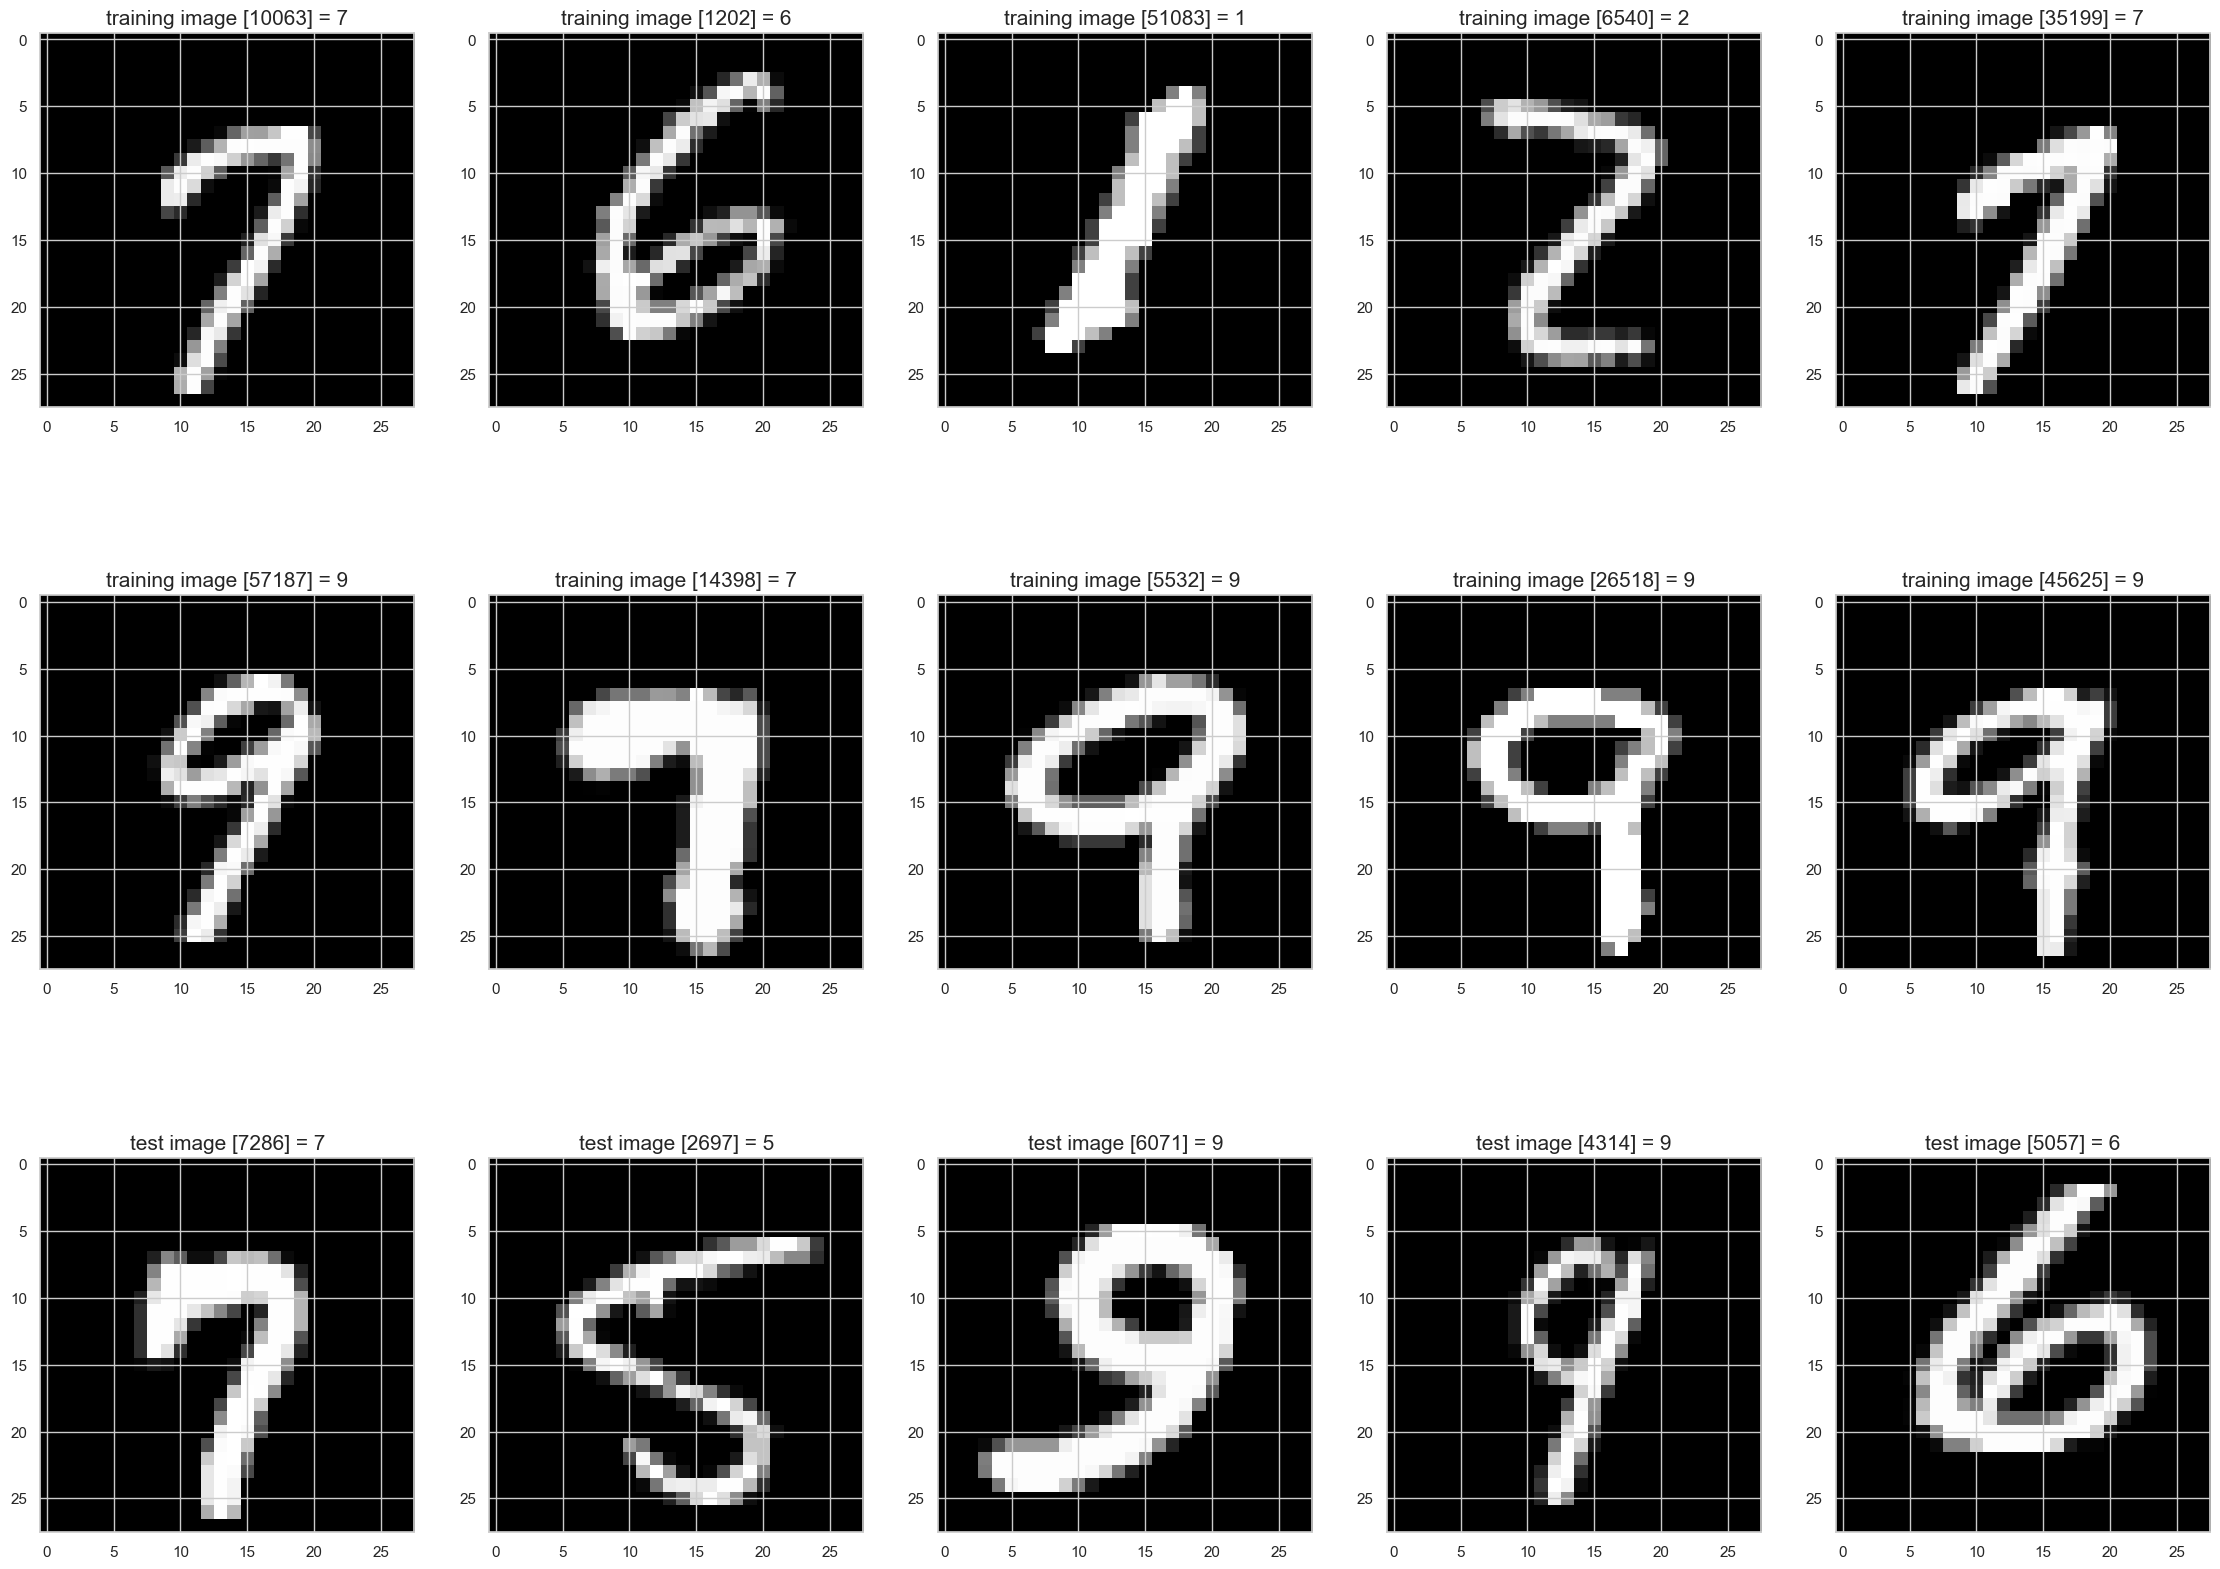

In [82]:
def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(28, 28))
    index = 1    
    for x in zip(images, title_texts):        
        image = x[0]        
        title_text = x[1]
        plt.subplot(rows, cols, index)        
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15)      
        index += 1

random_images = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    random_images.append((x_train[r], 'training image [' + str(r) + '] = ' + str(y_train[r])))
for i in range(0, 5):
    r = random.randint(1, 10000)
    random_images.append((x_test[r], 'test image [' + str(r) + '] = ' + str(y_test[r])))

show_images(list(map(lambda x: x[0], random_images)), list(map(lambda x: x[1], random_images)))

# 3. Строим модель нейронной сети

## 3.1. Определение функций и классов для нужных нам слоев 

In [83]:
# Функция нахождения ошибки 
def softmax_crossentropy_with_logits(logits, reference_answers):
    # список итоговых наибольших вероятностей среди своих входных наборов 
    logits_for_answers = logits[np.arange(len(logits)), reference_answers] 
 
    xentropy = - logits_for_answers + np.log(np.sum(np.exp(logits), axis=-1))    
    return xentropy

# Возвращает градиент функции потерь по вектору логитов
def grad_softmax_crossentropy_with_logits(logits, reference_answers):
    ones_for_answers = np.zeros_like(logits)
    ones_for_answers[np.arange(len(logits)), reference_answers] = 1    
    softmax = np.exp(logits) / np.exp(logits).sum(axis=-1,keepdims=True)    
    return (- ones_for_answers + softmax) / logits.shape[0]


class Layer(object):
    def __init__(self):        
        pass
    
    def forward(self, input):
        return input
    
    def backward(self, input, grad_output):
        num_units = input.shape[1] # кол-во данных, передающиеся в каждом примере 
            # (кол-во столбцов матрицы, где строки - примеры, столбцы - признаки)
        d_layer_d_input = np.eye(num_units)
        # Обычное умножение
        return np.dot(grad_output, d_layer_d_input) # chain rule

# Слой активации
class ReLU(Layer):
    def __init__(self):
        pass
    
    def forward(self, input):
        # Замена всех отрицательных значений на 0
        relu_forward = np.maximum(0, input)
        return relu_forward
    
    def backward(self, input, grad_output):
        relu_grad = input > 0
        # Поэлементное умножение
        return grad_output * relu_grad

# Слой обработки данных
class Dense(Layer):
    def __init__(self, input_units, output_units, learning_rate = 0.1):
        self.learning_rate = learning_rate
        self.weights = np.random.normal(loc=0.0, scale = np.sqrt(2 / (input_units + output_units)), size = (input_units, output_units))
        self.biases = np.zeros(output_units)
    
    def forward(self, input):
        # Аффинное преобразовние, происходящее по формуле: f(x) = W*x + b                        
        return np.dot(input, self.weights) + self.biases
    
    def backward(self, input, grad_output):
        # Df/DX^k = Df/DX^k+1 * W^T
        grad_input = np.dot(grad_output, self.weights.T)
        
        # W = input^T * grad_output
        grad_weights = np.dot(input.T, grad_output)
        # B = среднее значение градиента по нейронам * кол-во нейронов в примере
        grad_biases = grad_output.mean(axis=0) * input.shape[0]
        # Убеждаемся в корректности данных
        assert grad_weights.shape == self.weights.shape and grad_biases.shape == self.biases.shape
        
        # Здесь мы выполняем шаг стохастического градиентного спуска
        # W^k+1 = W^k - l * Df/DW^k
        self.weights = self.weights - self.learning_rate * grad_weights
        # B^k+1 = B^k - l * Df/DB^k
        self.biases = self.biases - self.learning_rate * grad_biases

        return grad_input

    
class MLP(object): # Multi-Layer Perceptron 
    def __init__(self): 
        # Инициализация массива слоев нейронной сети
        self.layers = []
        
    def add_layer(self, layer):
        # Функция добавления слоя в конец персептрона
        self.layers.append(layer)
    
    def forward(self, X):
        # Функция пропускает входные данные через все слои 
        # Возвращает список активаций
        activations = []
        input = X
        
        for layer in self.layers:
            # Слой активируется и добавляется в activatons
            activations.append(layer.forward(input))
            # Меняем входные данные на выходные данные предыдущего слоя
            input = activations[-1]
    
        assert len(activations) == len(self.layers)
        return activations
    
    # Функция проходящая до конца вперед и назад по 1 разу 
    # и меняющая веса на каждом слое
    def train_batch(self, X, y):
        # Проход по всем слоям
        layer_activations = self.forward(X)
        layer_inputs = [X] + layer_activations  # двумерный массив, где 
                                                # [0] - входные данные, 
                                                # [1, 2, ...] - активированные данные предыдущего слоя
        logits = layer_activations[-1]
        
        # Подсчет функции ошибки и ее градиента 
        # на первой итерации по всей нейронной сети  
        y_argmax = y.argmax(axis=1)        
        loss = softmax_crossentropy_with_logits(logits, y_argmax)
        loss_grad = grad_softmax_crossentropy_with_logits(logits, y_argmax)
    
        # Цикл, идущий с конца до начала нейронной сети,
        # меняя по пути веса на каждой связи между слоями
        for layer_index in range(len(self.layers))[::-1]:
            layer = self.layers[layer_index]        
            loss_grad = layer.backward(layer_inputs[layer_index], loss_grad) # grad w.r.t. input, also weight updates
        
        return np.mean(loss)
    
    def train(self, X_train, y_train, n_epochs = 25, batch_size = 32):
        train_log = []        
        
        for epoch in range(n_epochs):        
            for i in range(0, X_train.shape[0], batch_size):
                x_batch = np.array([x.flatten() for x in X_train[i:i + batch_size]])
                y_batch = np.array([y for y in y_train[i:i + batch_size]])        
                self.train_batch(x_batch, y_batch)
    
            train_log.append(np.mean(self.predict(X_train) == y_train.argmax(axis=-1)))                
            print(f"Epoch: {epoch + 1}, Train accuracy: {train_log[-1]}")                        
        return train_log
    
    # Возвращает результат прохода нейронной сети до конца
    def predict(self, X):
        logits = self.forward(X)[-1]
        return logits.argmax(axis=-1)

## 3.2. Создаем модель нейронной сети

In [84]:
# Функция преобразующая значения входного массива в диапазон от 0 до 1
def normalize(X):
    X_normalize = (X - np.min(X)) / (np.max(X) - np.min(X))
    return X_normalize   

def one_hot(a, num_classes):
    return np.squeeze(np.eye(num_classes)[a.reshape(-1)]) 

# Представляем каждое матричное отображение картинки в одномерное
X_train = normalize(np.array([np.ravel(x) for x in x_train]))
X_test = normalize(np.array([np.ravel(x) for x in x_test]))

# Представляем метки форма числа в нулевую матрицы из 10 элементов с 1 на индексе = метке 
Y_train = np.array([one_hot(np.array(y, dtype=int), 10) for y in y_train], dtype=int)
Y_test = np.array([one_hot(np.array(y, dtype=int), 10) for y in y_test], dtype=int)

print('X_train.shape', X_train.shape)
print('Y_train.shape', Y_train.shape)
input_size = X_train.shape[1]
output_size = Y_train.shape[1]

network = MLP()
network.add_layer(Dense(input_size, 100, learning_rate = 0.05))
network.add_layer(ReLU())
network.add_layer(Dense(100, 200, learning_rate = 0.05))
network.add_layer(ReLU())
network.add_layer(Dense(200, output_size))

X_train.shape (60000, 784)
Y_train.shape (60000, 10)


# 4. Тренируем нейронную сеть

In [85]:
train_log = network.train(X_train, Y_train, n_epochs = 32, batch_size = 64)

Epoch: 1, Train accuracy: 0.9251166666666667
Epoch: 2, Train accuracy: 0.94675
Epoch: 3, Train accuracy: 0.9586333333333333
Epoch: 4, Train accuracy: 0.9660666666666666
Epoch: 5, Train accuracy: 0.9717
Epoch: 6, Train accuracy: 0.9761833333333333
Epoch: 7, Train accuracy: 0.9798166666666667
Epoch: 8, Train accuracy: 0.9825166666666667
Epoch: 9, Train accuracy: 0.9842666666666666
Epoch: 10, Train accuracy: 0.9858
Epoch: 11, Train accuracy: 0.9872333333333333
Epoch: 12, Train accuracy: 0.9885166666666667
Epoch: 13, Train accuracy: 0.9893333333333333
Epoch: 14, Train accuracy: 0.99065
Epoch: 15, Train accuracy: 0.99125
Epoch: 16, Train accuracy: 0.99195
Epoch: 17, Train accuracy: 0.9924666666666667
Epoch: 18, Train accuracy: 0.9933333333333333
Epoch: 19, Train accuracy: 0.9937666666666667
Epoch: 20, Train accuracy: 0.9943
Epoch: 21, Train accuracy: 0.9945666666666667
Epoch: 22, Train accuracy: 0.995
Epoch: 23, Train accuracy: 0.99595
Epoch: 24, Train accuracy: 0.9963
Epoch: 25, Train accu

# 5. Отрисовываем график изменения точности

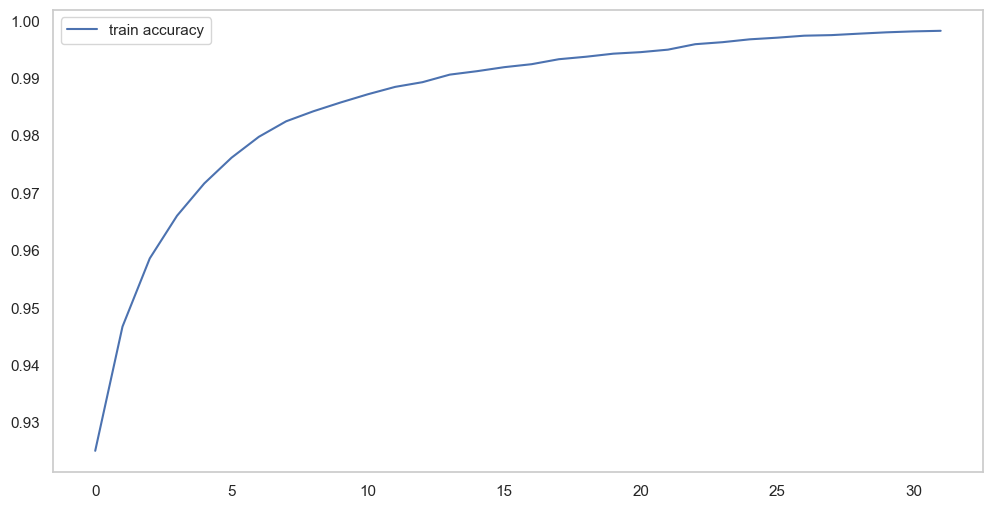

Test accuracy = 9766/10000 = 0.9766


In [86]:
plt.plot(train_log,label = 'train accuracy')
plt.legend(loc='best')
plt.grid()
plt.show()


test_corrects = len(list(filter(lambda x: x, network.predict(X_test) ==  Y_test.argmax(axis=-1))))
test_all = len(X_test)
test_accuracy = test_corrects / test_all #np.mean(test_errors)
print(f"Test accuracy = {test_corrects}/{test_all} = {test_accuracy}")

# 6. Получаем результат

## 6.1. Предсказываем ответ

In [87]:
network.predict(X_test[100:101])

array([6])

## 6.2. Отрисовываем число, которое мы пытались предсказать

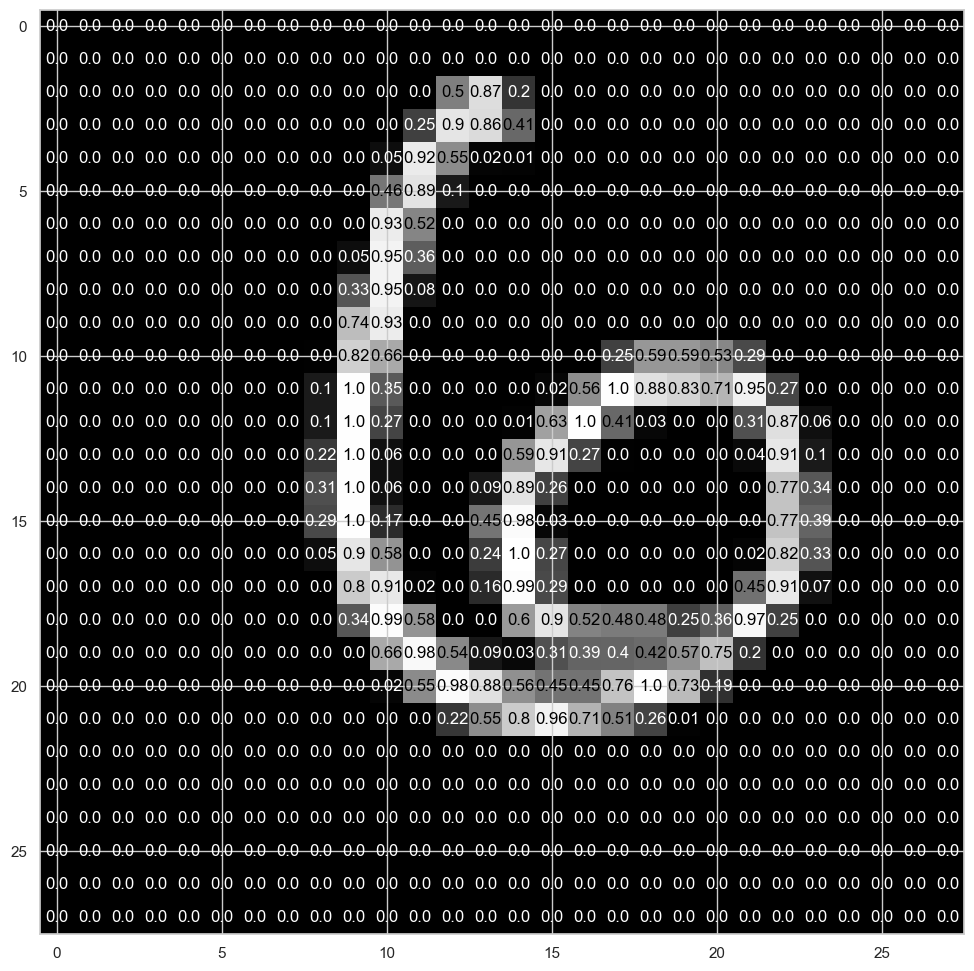

In [88]:
def visualize_input(img, ax):
    ax.imshow(img, cmap='gray')
    width, height = img.shape
    thresh = img.max()/2.5
    for x in range(width):
        for y in range(height):
            ax.annotate(str(round(img[x][y],2)), xy=(y,x),
                        horizontalalignment='center',
                        verticalalignment='center',
                        color='white' if img[x][y]<thresh else 'black')

fig = plt.figure(figsize = (12,12)) 
ax = fig.add_subplot(111)
visualize_input(X_test[100:101].reshape(28,28), ax)